In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import sklearn.linear_model as lm
import sklearn.svm as svm
import sklearn.ensemble as en
import warnings
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'
# path_to_git = '/home/kentaro/github/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

iic_burden.keys()

sns.set(font_scale=3,style='whitegrid')

In [3]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in (range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['D'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        

# Effect of IIC Burden on Outcome

# Controlling for age

In [645]:
m_dict_dict = {}
cates_dict_dict = {}
df_dict_dict = {}

for type_summary in tqdm.tqdm(['max','mean','proportion']):
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    df_coarsen_1 = df_coarsen[['Age',  
                               'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

    discrete = []
    
    baseline_threshold = 0.1
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<=baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
    
#     df_baseline_dict[type_summary] = df_coarsen_baseline
    num = []
    n_thresholds = 3
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    df_dict = {}
    
    df_means = pd.DataFrame(df_coarsen_baseline.mean(axis=0),columns=['Baseline'])
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] > threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<=upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_means_ = pd.DataFrame(df_coarsen_comparison.mean(axis=0),columns=['%.2f - %.2f'%(threshold,upper_threshold)])
        df_means = pd.concat([df_means,df_means_],axis=1)
        
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
        
        # malts object, match only on pre-treatment covariates
        n_repeats = 30
        n_splits = 3
        
        df_malts_data = (df_malts.drop(columns=['Y','T']).values - df_malts.drop(columns=['Y','T']).mean(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape))
        df_malts_data = pd.DataFrame(df_malts_data / (df_malts.drop(columns=['Y','T']).std(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape)), 
                                     columns=df_malts.drop(columns=['Y','T']).columns,index=df_malts.index)
        df_malts_data['Y'] = df_malts['Y'].values
        df_malts_data['T'] = df_malts['T'].values
        
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts_data.drop(columns=['mRS','E']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full',
                        k_tr=5,
                        k_est=5,
                        estimator='mean',
                        discrete = discrete,
                        C=0.01)
        
        # storing the malts object
        m_dict[threshold] = m
        df_dict[threshold] = df_malts
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = type_summary + str(threshold)
        
    m_dict_dict[type_summary] = m_dict
    cates_dict_dict[type_summary] = cates_dict
    df_dict_dict[type_summary] = df_dict
    df_means_dict[type_summary] = df_means

100%|██████████| 3/3 [1:35:12<00:00, 1904.26s/it]


In [646]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_dict = df_dict_dict[type_summary]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
#                                                                        & (m_dict[threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

In [647]:
for type_summary in df_m_atec_dict.keys():
    df_m_atec = df_m_atec_dict[type_summary]
    df_m_atec.to_csv('df_m_atec_'+type_summary+'_age.csv')

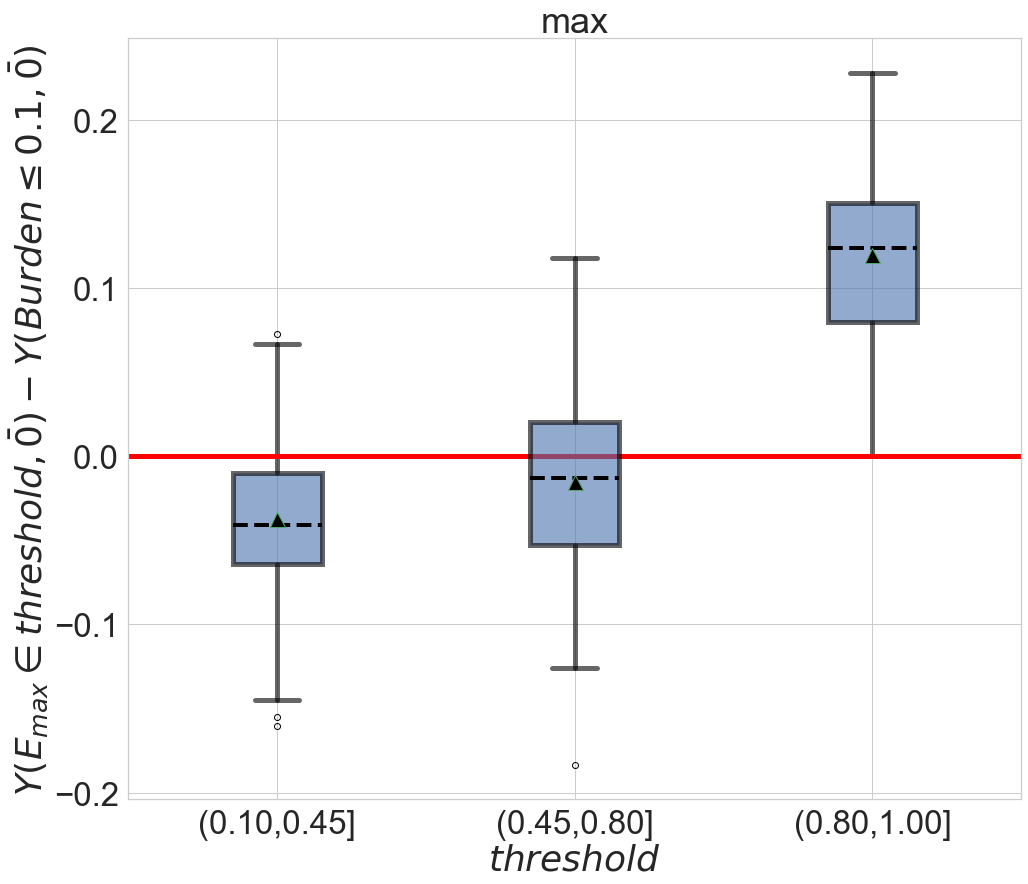

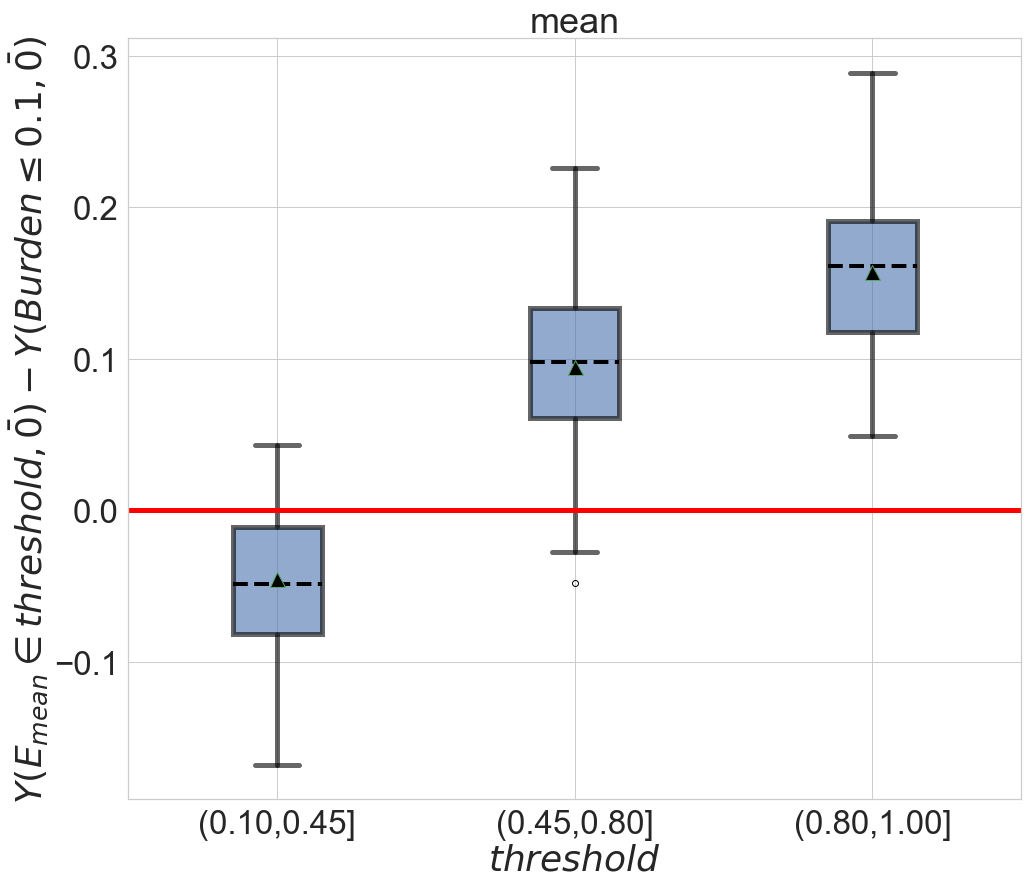

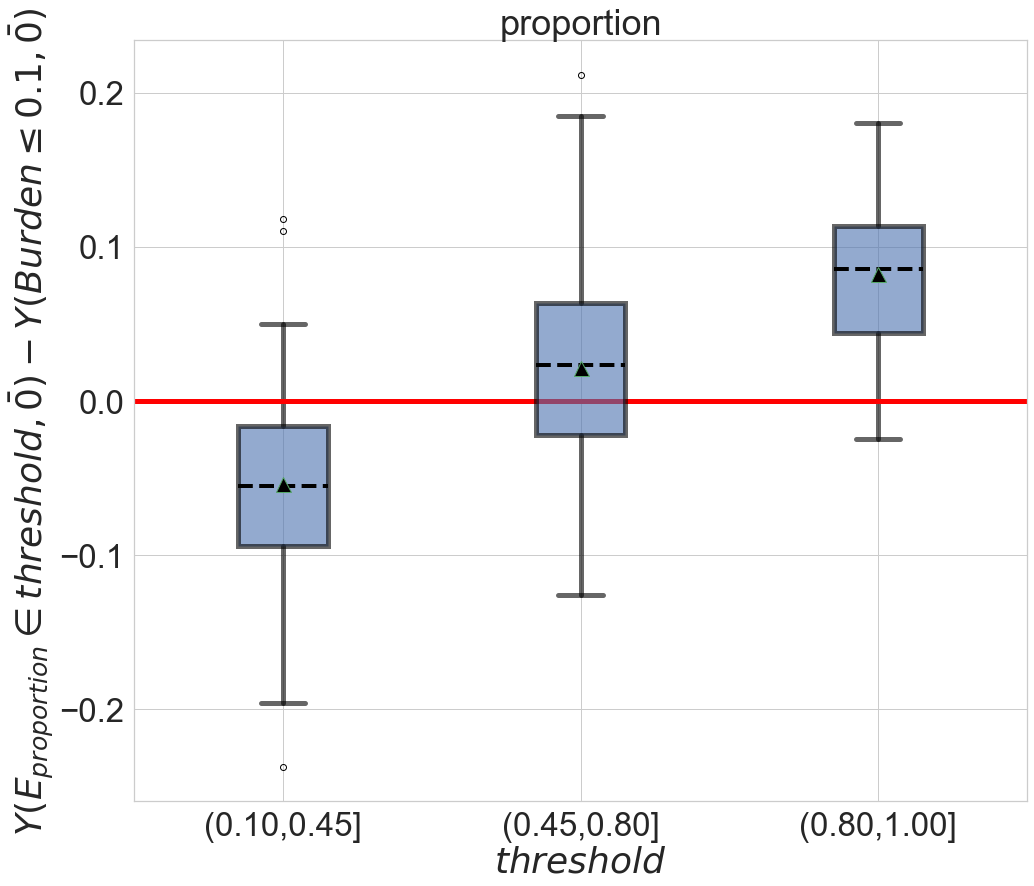

In [648]:
for type_summary in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(16,14))
    df_m_atec_dict[type_summary].T.plot(kind='box',showmeans=True,
                                        ax=ax,
                                        patch_artist=True,
#                                         meanline=True,
                                        capprops={'alpha':0.6,'lw':5},
                                        whiskerprops = {'alpha':0.6,'lw':5},
                                        boxprops={'alpha':0.6,'lw':5},
                                        medianprops={'lw':4,'color':'black','ls':'--'},
                                        meanprops={'markersize':15,'markerfacecolor':'black'})
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('$Y(E_{%s} \\in threshold, \\bar{0}) - Y(Burden \\leq 0.1,\\bar{0})$'%(type_summary))
    plt.xlabel('$threshold$')
    plt.title('%s'%(type_summary))
    fig.savefig(type_summary+'_age.png')

In [403]:
df_m_atec

,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE,...,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE
"(0.10,0.45]",-0.070968,-0.064957,-0.055652,-0.001709,-0.081034,-0.115447,-0.034711,-0.064865,-0.038710,0.086239,...,0.003509,-0.066667,-0.076562,0.005405,-0.121667,-0.071667,-0.027586,0.022222,-0.182143,0.006299
"(0.45,0.80]",0.140741,-0.067890,-0.003540,0.127273,-0.016807,-0.049505,0.018519,-0.079646,0.018349,-0.046847,...,-0.035398,-0.071429,0.054000,0.025424,0.020690,0.055357,-0.066667,0.013793,0.014286,-0.015686
"(0.80,1.00]",0.085207,0.022078,0.103401,0.101316,0.041212,0.100654,0.082635,0.055346,0.090278,0.061935,...,0.129560,0.087805,0.151282,0.014667,0.162264,-0.020382,0.080519,0.051948,0.104575,0.094479


# Controlling for all pre-admission covariates

In [649]:
m_dict_dict = {}
cates_dict_dict = {}
df_dict_dict = {}

for type_summary in tqdm.tqdm(['max','mean','proportion']):
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                               'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                               'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                               'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                               'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                               'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                               'Hx CNS cancer', 'Hx COPD/ Asthma', 
                               'premorbid MRS before admission  (modified ranking scale),before admission', 
                               'hydrocephalus  (either on admission or during hospital course)   QPID', 
                               'iMV  (initial (on admission) mechanical ventilation)',
                               'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
                               'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders',  
                               'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

    discrete = ['Gender', 'marrital','Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                'Hx CNS cancer', 'Hx COPD/ Asthma', 
                'premorbid MRS before admission  (modified ranking scale),before admission', 
                'hydrocephalus  (either on admission or during hospital course)   QPID', 
                'iMV  (initial (on admission) mechanical ventilation)',
                'Primary systemic dx Sepsis/Shock',
                'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders']
    
    baseline_threshold = 0.1
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<=baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
    
#     df_baseline_dict[type_summary] = df_coarsen_baseline
    num = []
    n_thresholds = 3
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    df_dict = {}
    
    df_means = pd.DataFrame(df_coarsen_baseline.mean(axis=0),columns=['Baseline'])
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] > threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<=upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_means_ = pd.DataFrame(df_coarsen_comparison.mean(axis=0),columns=['%.2f - %.2f'%(threshold,upper_threshold)])
        df_means = pd.concat([df_means,df_means_],axis=1)
        
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
        
        # malts object, match only on pre-treatment covariates
        n_repeats = 30
        n_splits = 3
        
        df_malts_data = (df_malts.drop(columns=['Y','T']).values - df_malts.drop(columns=['Y','T']).mean(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape))
        df_malts_data = pd.DataFrame(df_malts_data / (df_malts.drop(columns=['Y','T']).std(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape)), 
                                     columns=df_malts.drop(columns=['Y','T']).columns,index=df_malts.index)
        df_malts_data['Y'] = df_malts['Y'].values
        df_malts_data['T'] = df_malts['T'].values
        
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts_data.drop(columns=['mRS','E']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full',
                        k_tr=5,
                        k_est=5,
                        estimator='mean',
                        discrete = discrete,
                        C=0.01)
        
        # storing the malts object
        m_dict[threshold] = m
        df_dict[threshold] = df_malts
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = type_summary + str(threshold)
        
    m_dict_dict[type_summary] = m_dict
    cates_dict_dict[type_summary] = cates_dict
    df_dict_dict[type_summary] = df_dict
    df_means_dict[type_summary] = df_means





100%|██████████| 3/3 [2:12:27<00:00, 2649.14s/it]


In [650]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_dict = df_dict_dict[type_summary]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
                                                                       & (m_dict[threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

In [651]:
for type_summary in df_m_atec_dict.keys():
    df_m_atec = df_m_atec_dict[type_summary]
    df_m_atec.to_csv('df_m_atec_'+type_summary+'_c.csv')

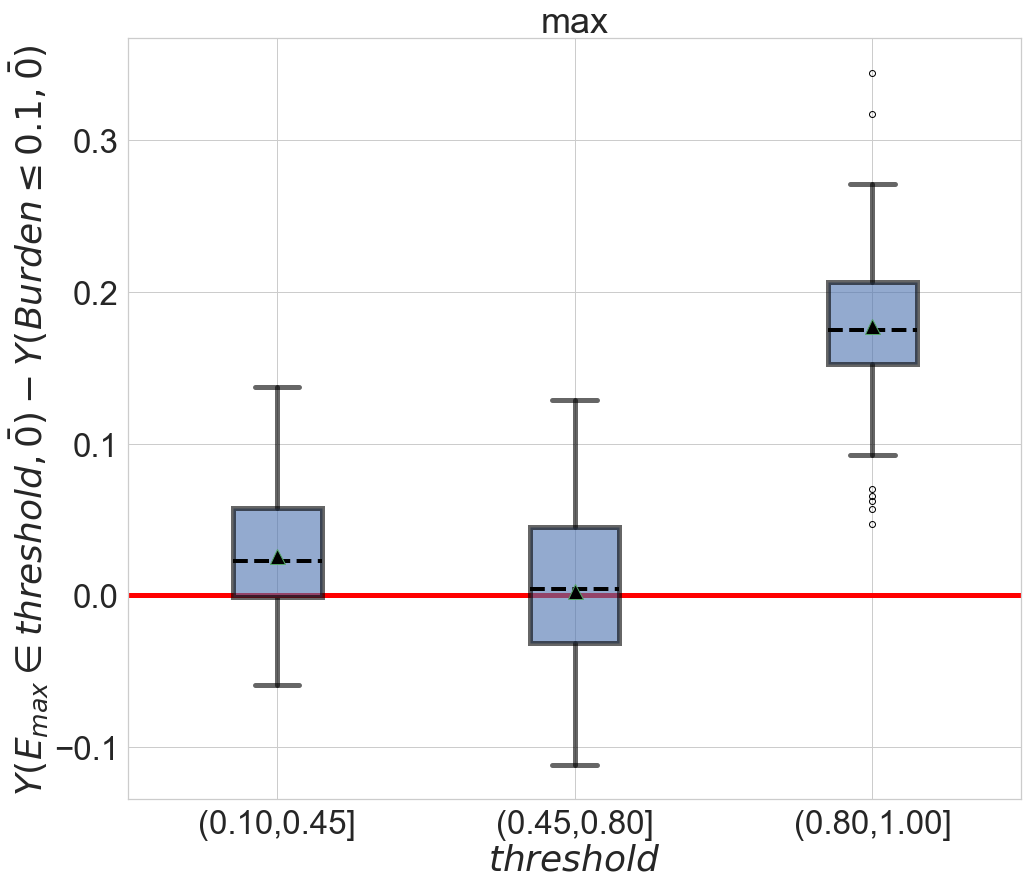

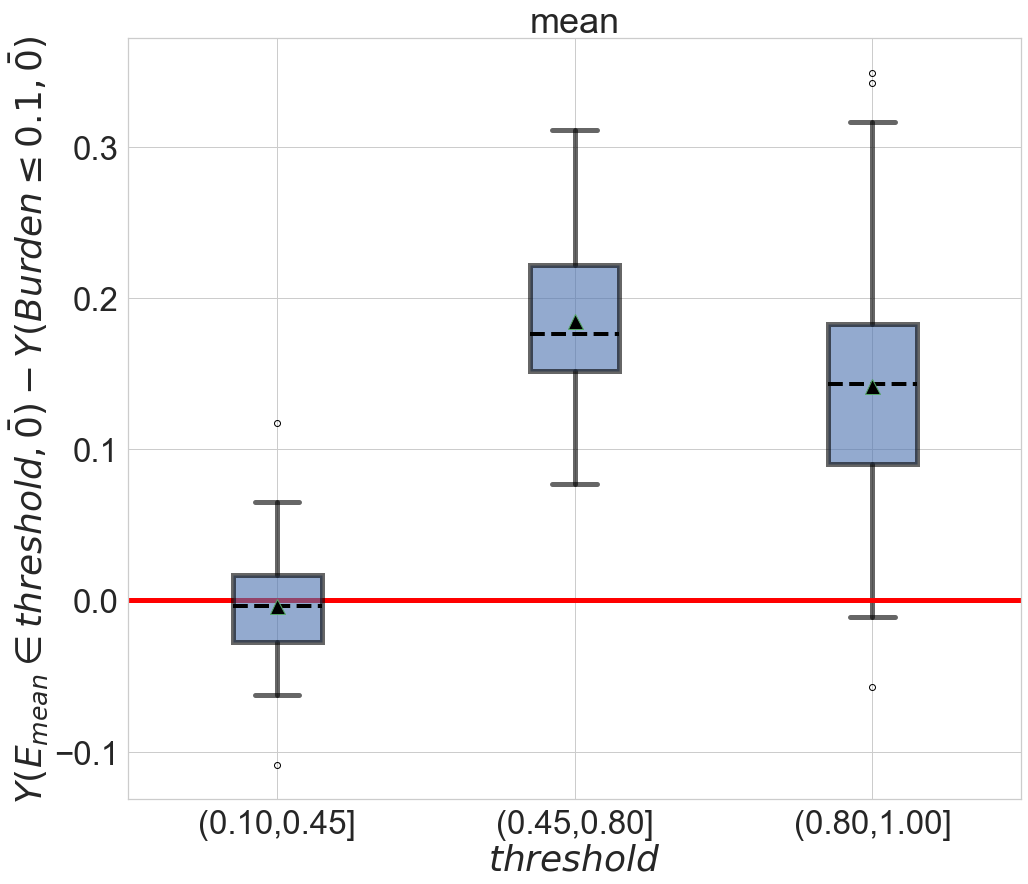

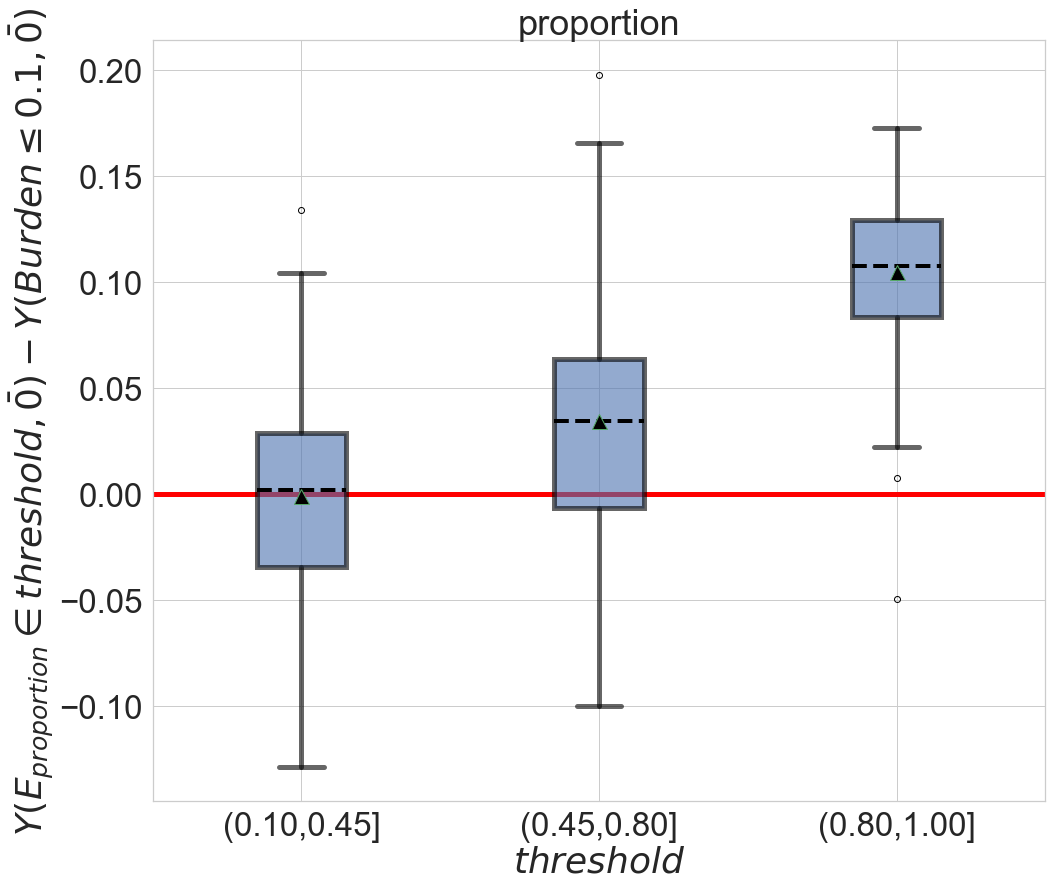

In [652]:
for type_summary in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(16,14))
    df_m_atec_dict[type_summary].T.plot(kind='box',showmeans=True,
                                        ax=ax,
                                        patch_artist=True,
#                                         meanline=True,
                                        capprops={'alpha':0.6,'lw':5},
                                        whiskerprops = {'alpha':0.6,'lw':5},
                                        boxprops={'alpha':0.6,'lw':5},
                                        medianprops={'lw':4,'color':'black','ls':'--'},
                                        meanprops={'markersize':15,'markerfacecolor':'black'})
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('$Y(E_{%s} \\in threshold, \\bar{0}) - Y(Burden \\leq 0.1,\\bar{0})$'%(type_summary))
    plt.xlabel('$threshold$')
    plt.title('%s'%(type_summary))
    fig.savefig(type_summary+'_c.png')

In [173]:
threshold = list(m_dict.keys())[3]
df_m_ate_ = m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                               & (df_dict[threshold]['propofol']<=1) 
                               & (df_dict[threshold]['midazolam']<=0.1)
                               & (df_dict[threshold]['lacosamide']<=0.1)
                               & (df_dict[threshold]['pentobarbital']<=0)
                               & (df_dict[threshold]['phenobarbital']<=0)
                               & (df_dict[threshold]['valproate']<=1)]
M_ = pd.concat(m_dict[threshold].M_opt_list)
MG_ = m_dict[threshold].MG_matrix.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                               & (df_dict[threshold]['propofol']<=1) 
                               & (df_dict[threshold]['midazolam']<=0)
                               & (df_dict[threshold]['lacosamide']<=0)
                               & (df_dict[threshold]['pentobarbital']<=0)
                               & (df_dict[threshold]['phenobarbital']<=0)
                               & (df_dict[threshold]['valproate']<=0)]
df_m_ate_[['T']].shape

(141, 1)

In [174]:
MG_0 = MG_.iloc[1]
MG_0 = MG_0[MG_0>0]
df_dict[threshold].loc[list(MG_0.index)].join(df_m_ate_[['avg.CATE','std.CATE','avg.Diameter']],how='inner').groupby('T').mean().T

T,False,True
Gender,0.531250,0.625000
Age,64.753750,60.625625
marrital,0.750000,0.562500
Hx CVA (including TIA),0.218750,0.125000
Hx HTN,0.656250,0.812500
Hx Sz /epilepsy,0.062500,0.375000
Hx brain surgery,0.062500,0.312500
Hx CKD,0.156250,0.000000
Hx CAD/MI,0.125000,0.187500
Hx CHF,0.031250,0.000000


<AxesSubplot:xlabel='avg.Diameter', ylabel='avg.CATE'>

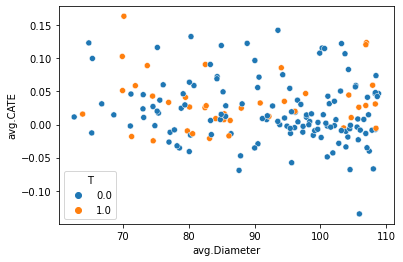

In [186]:
j = 3
cutoff = pd.concat(m_dict[list(m_dict.keys())[j]].M_opt_list).mean(axis=0).sort_values(ascending=False).sum()
# sns.scatterplot(data=df_m_ate_.loc[df_m_ate_['avg.Diameter']<400],x='avg.Diameter',y='avg.CATE')
sns.scatterplot(data=m_dict[list(m_dict.keys())[j]].CATE_df.loc[m_dict[list(m_dict.keys())[j]].CATE_df['avg.Diameter']<3*cutoff],x='avg.Diameter',y='avg.CATE',hue='T')

In [177]:
pd.concat(m_dict[list(m_dict.keys())[3]].M_opt_list).mean(axis=0).sort_values(ascending=False).sum()

36.36939398353506

In [178]:
pd.concat([pd.DataFrame(M_.mean(axis=0),columns=['mean']),pd.DataFrame(M_.min(axis=0),columns=['min']),pd.DataFrame(M_.max(axis=0),columns=['max'])],axis=1).sort_values(ascending=False,by='mean')

,mean,min,max
Age,1.566882,0.740884,2.260887
Hx CAD/MI,1.473368,0.658891,2.171397
Primary systemic dx Sepsis/Shock,1.432050,0.790735,2.135878
Hx CKD,1.404262,0.492308,2.600821
Hx CHF,1.387137,0.782976,2.365020
Hx CNS cancer,1.378336,0.436985,2.402994
midazolam,1.377397,0.240132,2.393124
propofol,1.309093,0.421461,2.130723
Worst GCS in 1st 24,1.221636,0.509815,2.633010
phenobarbital,1.213367,0.218100,2.411839


In [180]:
df_means

,Baseline,0.10 - 0.28,0.28 - 0.45,0.45 - 0.62,0.62 - 0.80,0.80 - 1.00
Gender,0.510490,0.502392,0.402985,0.530973,0.495935,0.460630
Age,58.091725,58.859904,58.896194,60.049558,60.937398,61.140709
marrital,0.475524,0.468900,0.470149,0.530973,0.479675,0.586614
Hx CVA (including TIA),0.186480,0.196172,0.156716,0.212389,0.170732,0.208661
Hx HTN,0.496503,0.492823,0.544776,0.504425,0.601626,0.566929
Hx Sz /epilepsy,0.142191,0.200957,0.171642,0.221239,0.203252,0.228346
Hx brain surgery,0.048951,0.114833,0.134328,0.123894,0.146341,0.161417
Hx CKD,0.118881,0.081340,0.141791,0.079646,0.130081,0.149606
Hx CAD/MI,0.174825,0.129187,0.134328,0.176991,0.203252,0.145669
Hx CHF,0.062937,0.086124,0.082090,0.097345,0.113821,0.114173


# Controlling for all pre-admission covariates and PKPD parameters

In [653]:
m_dict_dict = {}
cates_dict_dict = {}
df_dict_dict = {}
df_means_dict = {}

df_pkpd = pd.read_csv('../aim1/step6_simulator/results_iic_burden_smooth/params_mean_CNNIIC_iic_burden_smooth_cauchy_expit_lognormal_drugoutside_ARMA2,6_iter1000.csv',
                     index_col=0, header=0)

df_pkpd = df_pkpd[['alpha0', 'alpha[1]','alpha[2]', 'b[lacosamide]', 'b[levetiracetam]',
                   'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 'b[propofol]','b[valproate]']].fillna(0)

for type_summary in tqdm.tqdm(['max','mean','proportion']):
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    
    df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                               'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                               'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                               'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                               'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                               'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                               'Hx CNS cancer', 'Hx COPD/ Asthma', 
                               'premorbid MRS before admission  (modified ranking scale),before admission',  
                               'iMV  (initial (on admission) mechanical ventilation)',
                               'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
                               'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders',  
                               'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()
    
    df_coarsen_1 = df_coarsen_1.join(df_pkpd,how='inner')

    discrete = ['Gender', 'marrital','Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                'Hx CNS cancer', 'Hx COPD/ Asthma', 
                'premorbid MRS before admission  (modified ranking scale),before admission',
                'iMV  (initial (on admission) mechanical ventilation)',
                'Primary systemic dx Sepsis/Shock',
                'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders']
    
    baseline_threshold = 0.1
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<=baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
#     df_baseline_dict[type_summary] = df_coarsen_baseline
    num = []
    n_thresholds = 3
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    df_dict = {}
    
    df_means = pd.DataFrame(df_coarsen_baseline.mean(axis=0),columns=['Baseline'])
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] > threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<=upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_means_ = pd.DataFrame(df_coarsen_comparison.mean(axis=0),columns=['%.2f - %.2f'%(threshold,upper_threshold)])
        df_means = pd.concat([df_means,df_means_],axis=1)
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
         
        # malts object, match only on pre-treatment covariates
        n_repeats = 30
        n_splits = 3
        
        df_malts_data = (df_malts.drop(columns=['Y','T']).values - df_malts.drop(columns=['Y','T']).mean(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape))
        df_malts_data = pd.DataFrame(df_malts_data / (df_malts.drop(columns=['Y','T']).std(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape)), 
                                     columns=df_malts.drop(columns=['Y','T']).columns,index=df_malts.index)
        df_malts_data['Y'] = df_malts['Y'].values
        df_malts_data['T'] = df_malts['T'].values
        
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts_data.drop(columns=['mRS','E']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full',
                        k_tr=5,
                        k_est=5,
                        estimator='mean',
                        discrete = discrete,
                        C=0.01)
        
        # storing the malts object
        m_dict[threshold] = m
        df_dict[threshold] = df_malts
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = type_summary + str(threshold)
        
    m_dict_dict[type_summary] = m_dict
    cates_dict_dict[type_summary] = cates_dict
    df_dict_dict[type_summary] = df_dict
    df_means_dict[type_summary] = df_means






100%|██████████| 3/3 [2:22:40<00:00, 2853.49s/it]


In [654]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_dict = df_dict_dict[type_summary]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
                                                                       & (m_dict[threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

In [655]:
for type_summary in df_m_atec_dict.keys():
    df_m_atec = df_m_atec_dict[type_summary]
    df_m_atec.to_csv('df_m_atec_'+type_summary+'_c_pkpd.csv')

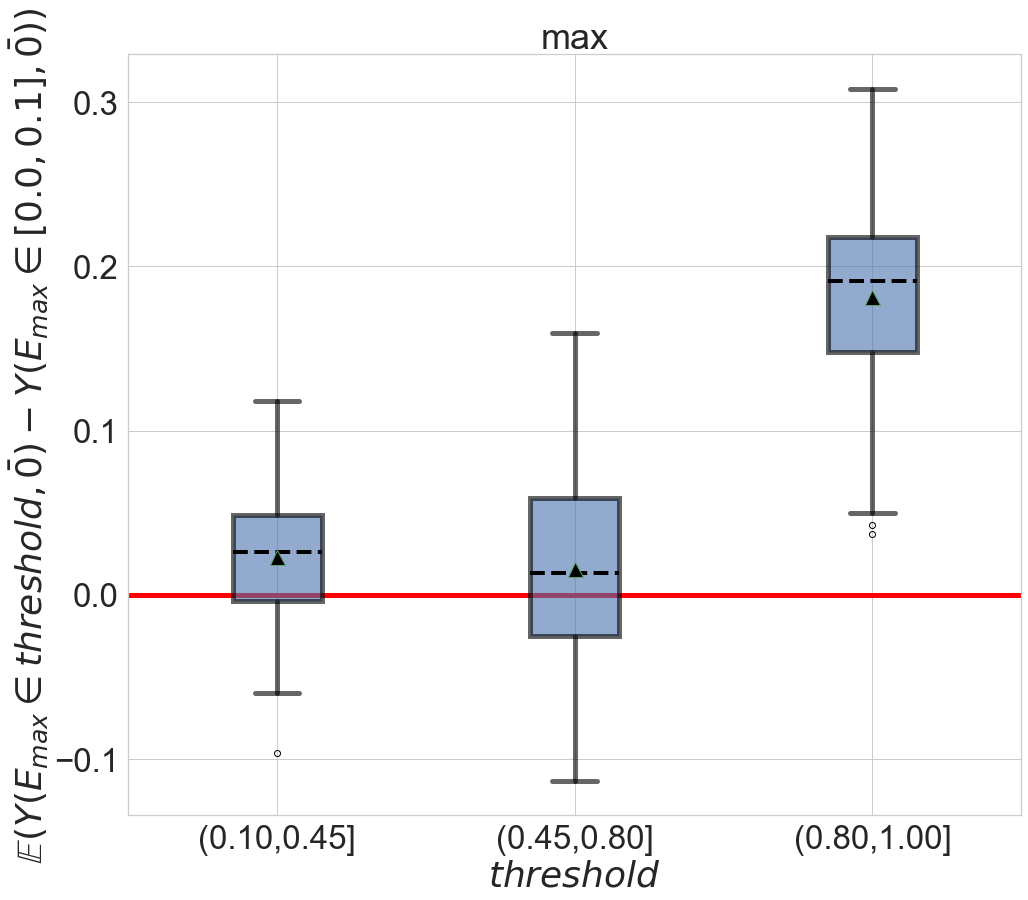

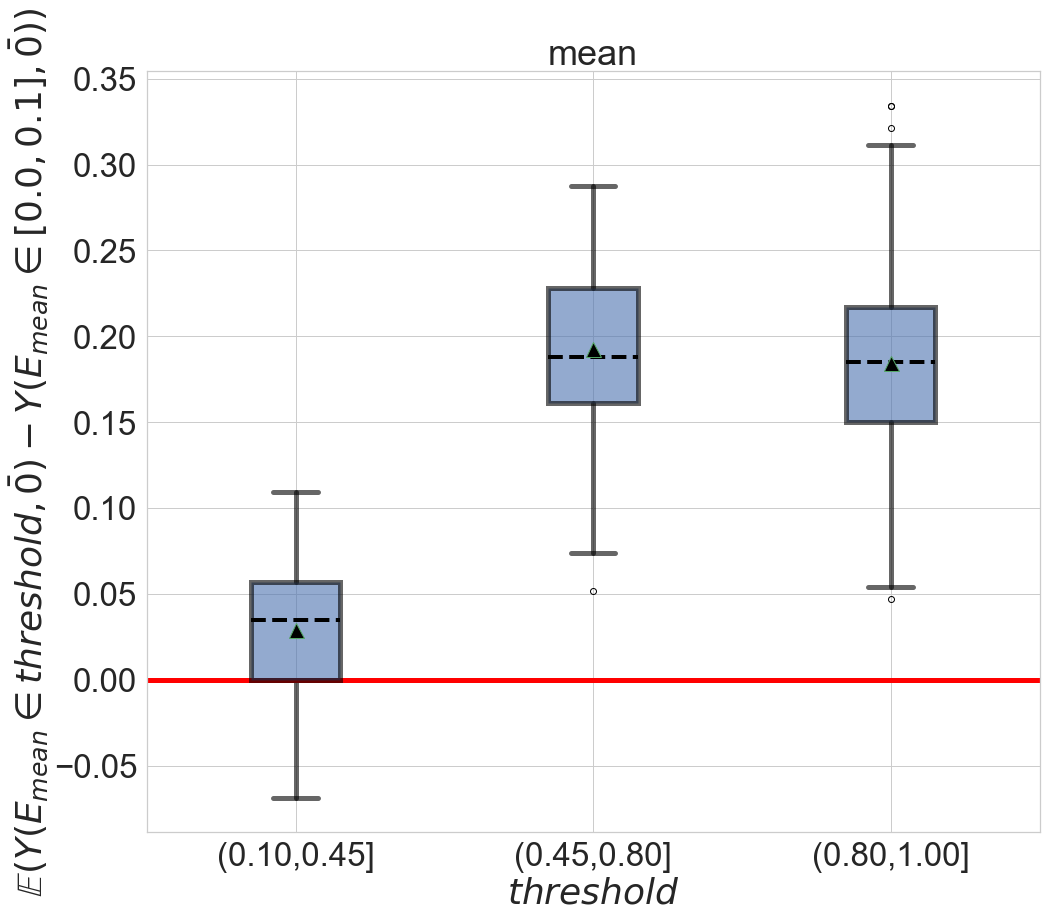

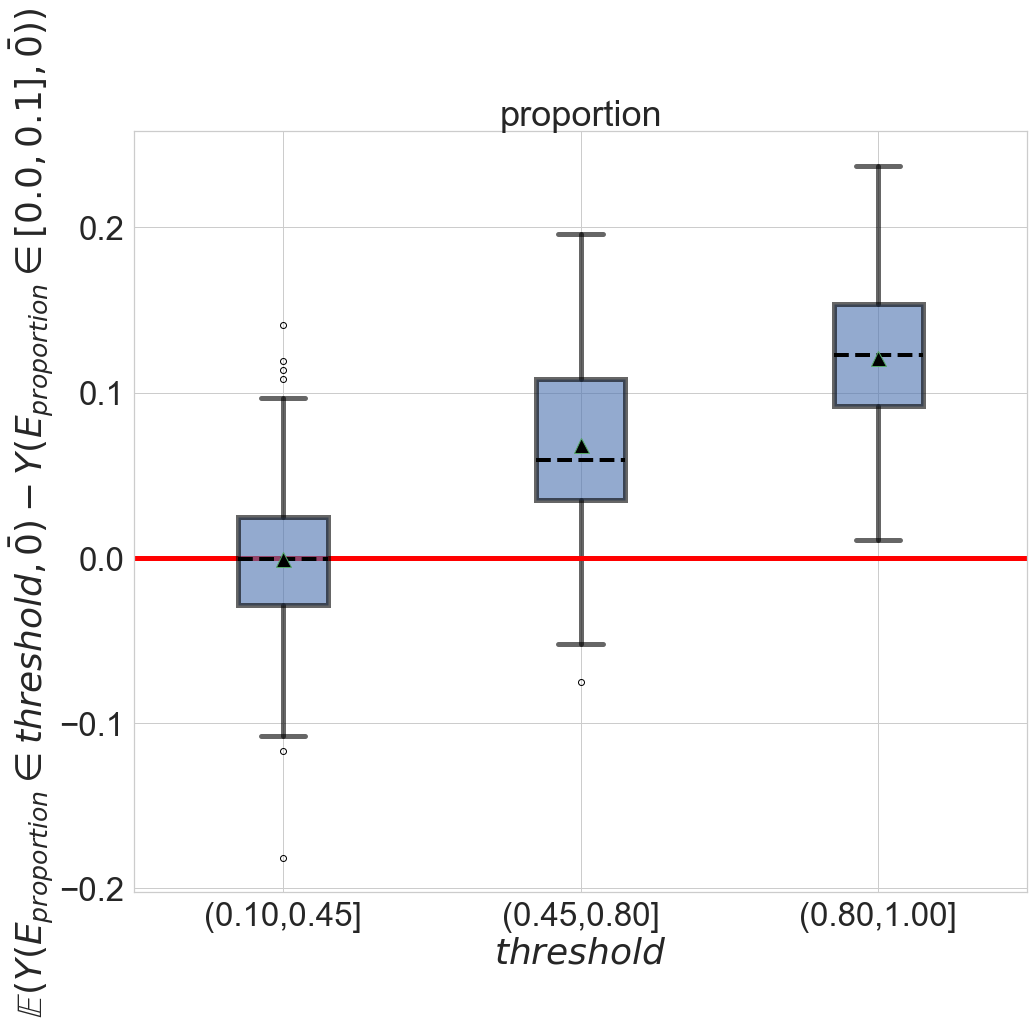

In [659]:
for type_summary in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(16,14))
    df_m_atec_dict[type_summary].T.plot(kind='box',showmeans=True,
                                        ax=ax,
                                        patch_artist=True,
#                                         meanline=True,
                                        capprops={'alpha':0.6,'lw':5},
                                        whiskerprops = {'alpha':0.6,'lw':5},
                                        boxprops={'alpha':0.6,'lw':5},
                                        medianprops={'lw':4,'color':'black','ls':'--'},
                                        meanprops={'markersize':15,'markerfacecolor':'black'})
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('$\\mathbb{E}(Y(E_{%s} \\in threshold, \\bar{0}) - Y(E_{%s} \\in [0.0,0.1],\\bar{0}))$'%(type_summary,type_summary))
    plt.xlabel('$threshold$')
    plt.title('%s'%(type_summary))
    fig.savefig(type_summary+'_c_pkpd.png')

In [413]:
pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum()

43.67706136884787

In [414]:
df_means

,Baseline,0.10 - 0.45,0.45 - 0.80,0.80 - 1.00
Gender,0.514344,0.461883,0.519774,0.468912
Age,57.679775,59.519776,59.789944,61.013575
marrital,0.473361,0.475336,0.474576,0.569948
Hx CVA (including TIA),0.182377,0.170404,0.180791,0.220207
Hx HTN,0.485656,0.511211,0.553672,0.567358
Hx Sz /epilepsy,0.149590,0.183857,0.186441,0.235751
Hx brain surgery,0.063525,0.076233,0.124294,0.181347
Hx CKD,0.125000,0.085202,0.124294,0.126943
Hx CAD/MI,0.165984,0.139013,0.180791,0.158031
Hx CHF,0.065574,0.125561,0.067797,0.101036


# Heterogeneous Effects

In [425]:
type_summary = 'max'
threshold = 0.8
df_analysis = df_dict_dict[type_summary][threshold].join(m_dict_dict[type_summary][threshold].CATE_df['avg.CATE']).loc[(df_dict_dict[type_summary][threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict_dict[type_summary][threshold]['propofol']<=1) 
                                                                       & (df_dict_dict[type_summary][threshold]['midazolam']<=0.1)
                                                                       & (df_dict_dict[type_summary][threshold]['lacosamide']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['pentobarbital']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['phenobarbital']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['valproate']<=0)
                                                                       & (m_dict_dict[type_summary][threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])]

In [426]:
import sklearn.tree as tree

In [475]:
ex_model = tree.DecisionTreeRegressor(max_leaf_nodes=8,min_samples_leaf=15,min_impurity_decrease=0.0001).fit(df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']),
                                                            df_analysis['avg.CATE'])
# df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]','premorbid MRS before admission  (modified ranking scale),before admission'])

[Text(620.0, 733.86, 'Age <= 58.89\nmse = 0.006\nsamples = 156\nvalue = 0.186'),
 Text(372.0, 570.78, 'mechanical ventilation <= 0.5\nmse = 0.007\nsamples = 71\nvalue = 0.217'),
 Text(248.0, 407.70000000000005, 'Age <= 44.615\nmse = 0.008\nsamples = 50\nvalue = 0.238'),
 Text(124.0, 244.62, 'mse = 0.011\nsamples = 17\nvalue = 0.281'),
 Text(372.0, 244.62, 'Worst GCS in 1st 24 <= 14.5\nmse = 0.004\nsamples = 33\nvalue = 0.215'),
 Text(248.0, 81.54000000000008, 'mse = 0.004\nsamples = 16\nvalue = 0.239'),
 Text(496.0, 81.54000000000008, 'mse = 0.004\nsamples = 17\nvalue = 0.194'),
 Text(496.0, 407.70000000000005, 'mse = 0.001\nsamples = 21\nvalue = 0.168'),
 Text(868.0, 570.78, 'Age <= 72.33\nmse = 0.004\nsamples = 85\nvalue = 0.16'),
 Text(744.0, 407.70000000000005, 'mse = 0.003\nsamples = 49\nvalue = 0.175'),
 Text(992.0, 407.70000000000005, 'mse = 0.004\nsamples = 36\nvalue = 0.139')]

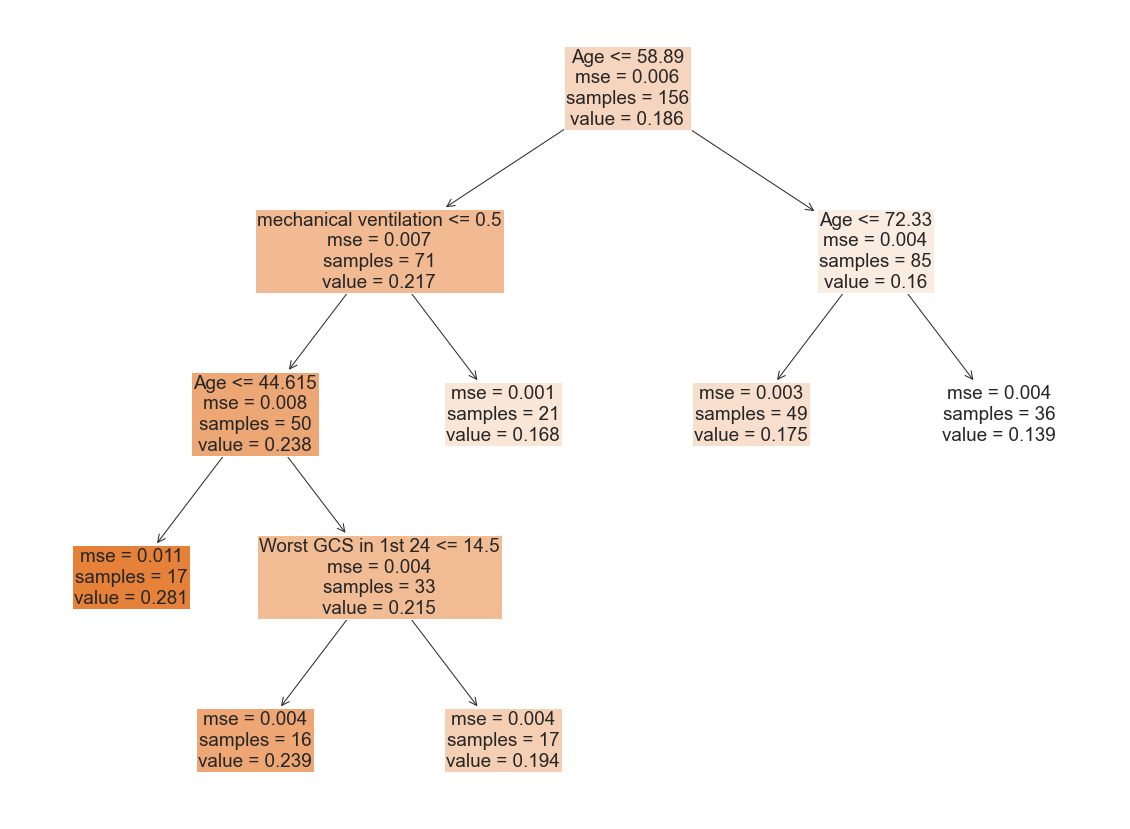

In [476]:

fig,ax = plt.subplots(figsize=(20,15))
tree.plot_tree(ex_model,feature_names=df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).rename(columns={'premorbid MRS before admission  (modified ranking scale),before admission':'preadmission mRS','iMV  (initial (on admission) mechanical ventilation)':'mechanical ventilation'}).columns,filled=True)

In [477]:
import sklearn.ensemble as en

In [511]:
ex_model_ada = en.AdaBoostRegressor(n_estimators=1000).fit(df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']),
                                                            df_analysis['avg.CATE'])

In [512]:
df_analysis['avg.CATE']

sid26      0.092503
sid28      0.023016
sid71      0.230181
sid87      0.216212
sid102     0.261155
             ...   
sid1886    0.130522
sid1898    0.128107
sid1950    0.108831
sid1997    0.174807
sid1999    0.194611
Name: avg.CATE, Length: 156, dtype: float64

In [533]:
age_range = np.arange(18,80)
dumy_x_0 = np.zeros((len(age_range),df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).shape[1]))
dumy_x_1 = np.ones((len(age_range),df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).shape[1]))
dumy_x_0[:,1] = age_range
dumy_x_1[:,1] = age_range
acc_res_0 = 0
acc_res_1 = 0
counter = 0
for estimator in ex_model_ada.estimators_:
    if estimator.feature_importances_[1]>0:
        acc_res_0 += estimator.predict(dumy_x_0)
        acc_res_1 += estimator.predict(dumy_x_1)
        counter += 1
acc_res_0 = acc_res_0/counter
acc_res_1 = acc_res_1/counter

<AxesSubplot:>

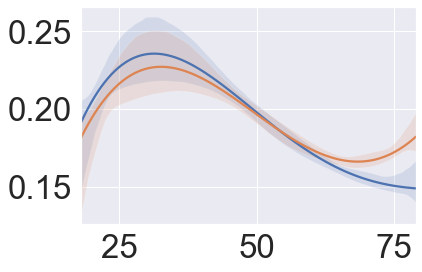

In [537]:
sns.regplot(age_range,acc_res_0,order=4,scatter=False)
sns.regplot(age_range,acc_res_1,order=4,scatter=False)

In [483]:
for type_summary in m_dict_dict.keys():
    for threshold in m_dict_dict[type_summary].keys():
        m_dict_dict[type_summary][threshold].CATE_df.to_csv('CATES_%s_%.0f.csv'%(type_summary,threshold*10))
        m_dict_dict[type_summary][threshold].MG_matrix.to_csv('MG_%s_%.0f.csv'%(type_summary,threshold*10))
        df_dict_dict[type_summary][threshold].to_csv('df_malts_estimation_set_%s_%.0f.csv'%(type_summary,threshold*10))
    df_means_dict[type_summary].to_csv('descriptive_summary_estimation_set_%s.csv'%(type_summary))

In [484]:
age_range = np.arange(18,80)

In [485]:
age_range

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

In [539]:
df_control_max = df_dict_dict['max'][0.8].loc[df_dict_dict['max'][0.8]['T']==0]

<AxesSubplot:xlabel='Age', ylabel='Y'>

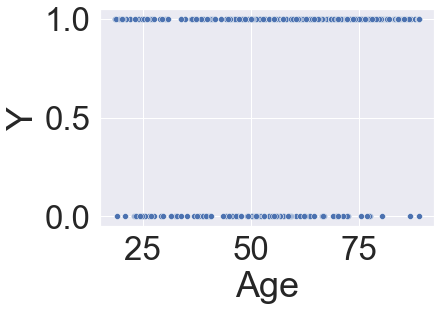

In [543]:
sns.scatterplot(data=df_control_max,y='Y',x='Age')

In [592]:
columns = ['20-40','40-60','70+']
index = ['% mRS $\\leq$ 3','% mRS > 3']
mat = np.zeros((2,3))
for i in df_control_max.index:
    age = df_control_max.loc[i,'Age']
    y = df_control_max.loc[i,'Y']
    if age<40:
        mat[int(y),0] += 1
    elif age<60:
        mat[int(y),1] += 1
    elif age>60:
        mat[int(y),2] += 1
mat[:,0] = mat[:,0]*100.0/np.sum(mat[:,0])
mat[:,1] = mat[:,1]*100.0/np.sum(mat[:,1])
mat[:,2] = mat[:,2]*100.0/np.sum(mat[:,2])
df_mat = pd.DataFrame(mat,columns=columns,index=index)

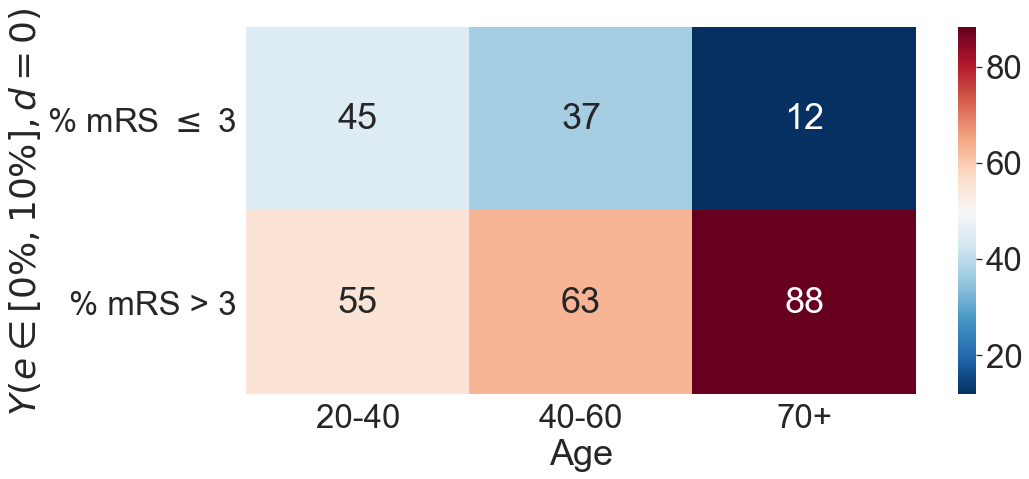

In [599]:
plt.figure(figsize=(15,6.75))
sns.heatmap(df_mat,annot=True,cmap="RdBu_r")
plt.ylabel('$Y(e \\in [0\%,10\%], d = 0 )$')
plt.xlabel('Age')
plt.savefig('y0_age.png')

In [597]:
m_dict_dict['max'][0.8].CATE_df.loc[df_dict_dict['max'][0.8]['T']==0]

,CATE,CATE,CATE,CATE,CATE,CATE,CATE,CATE,CATE,CATE,...,CATE,CATE,CATE,avg.CATE,std.CATE,Y,T,avg.Diameter,std.gbr.CATE,avg.gbr.CATE
sid5,0.8,NaN,0.4,0.4,NaN,1.0,0.2,0.4,NaN,0.4,...,0.2,0.6,NaN,0.207864,0.124574,0.0,0.0,154.573237,0.124574,0.207864
sid12,0.0,0.2,NaN,NaN,0.0,0.0,-0.2,0.2,NaN,NaN,...,NaN,0.0,-0.2,0.141449,0.120440,1.0,0.0,79.095415,0.120440,0.141449
sid15,0.0,NaN,0.2,0.0,0.0,NaN,NaN,0.2,0.2,NaN,...,0.0,0.2,NaN,0.162618,0.113265,1.0,0.0,65.354233,0.113265,0.162618
sid36,0.2,NaN,-0.2,NaN,0.2,0.2,0.0,NaN,0.2,0.0,...,0.2,NaN,0.0,0.214424,0.123882,1.0,0.0,79.663437,0.123882,0.214424
sid42,0.2,NaN,0.2,NaN,0.0,0.0,NaN,0.2,0.0,0.0,...,NaN,0.4,0.0,0.195259,0.131684,1.0,0.0,53.454865,0.131684,0.195259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sid1929,NaN,0.2,0.6,0.2,NaN,0.0,NaN,0.0,0.2,NaN,...,0.2,0.0,NaN,0.133313,0.129617,0.0,0.0,214.906103,0.129617,0.133313
sid1960,NaN,0.0,0.0,0.2,0.2,NaN,0.2,NaN,0.0,0.0,...,0.2,NaN,0.4,0.187529,0.120669,1.0,0.0,45.323636,0.120669,0.187529
sid1985,NaN,0.4,0.0,NaN,0.4,0.2,0.2,NaN,-0.2,0.6,...,0.2,NaN,0.0,0.151802,0.121401,1.0,0.0,47.673002,0.121401,0.151802
sid1997,NaN,-0.2,0.0,NaN,0.2,0.2,NaN,0.0,0.0,-0.2,...,0.0,NaN,0.6,0.174807,0.121361,1.0,0.0,74.836218,0.121361,0.174807


In [661]:
type_summary = 'max'
threshold = 0.8
gph = m_dict_dict[type_summary][threshold].MG_matrix

In [662]:
import networkx

In [738]:
G_max_8 = networkx.from_pandas_adjacency((gph>24).astype(int))

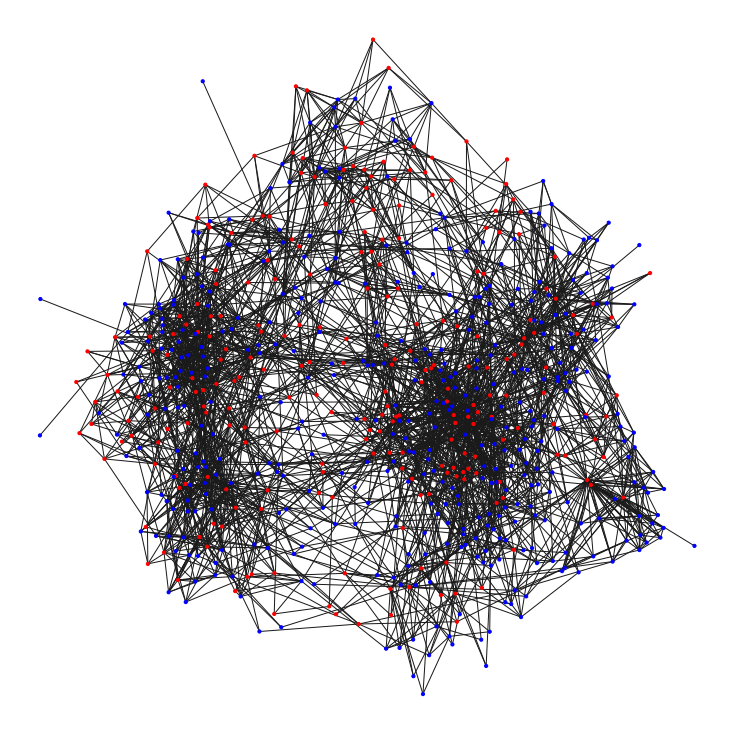

In [703]:
fig = plt.figure(figsize=(10,10))
node_color = [ 'red' if df_dict_dict[type_summary][threshold].loc[i,'T']==1 else 'blue' for i in (df_dict_dict[type_summary][threshold].index) ]
networkx.draw(G_max_8,node_size=10,node_color=node_color)

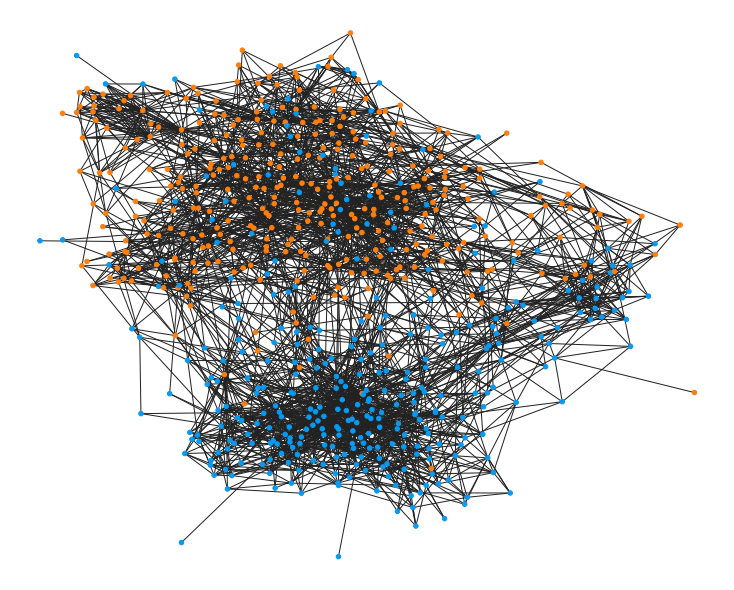

In [739]:
fig = plt.figure(figsize=(10,8))
node_color = [ '#ff7f0e' if df_dict_dict[type_summary][threshold]['iMV  (initial (on admission) mechanical ventilation)'].loc[i]==1 else '#069af3' for i in (df_dict_dict[type_summary][threshold].index) ]
networkx.draw(G_max_8,node_size=20,node_color=node_color,edge_color='#222222')
fig.savefig('iMV_mg_c_pkpd_viz.png')

In [744]:
df_dict_dict[type_summary][threshold].columns

Index(['Gender', 'Age', 'marrital', 'Hx CVA (including TIA)', 'Hx HTN',
       'Hx Sz /epilepsy', 'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
       'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)',
       'Hx ETOH abuse any time in their life (just when in the hx is mentioned)',
       'Hx other substance abuse, any time in their life',
       'Hx cancer (other than CNS cancer)', 'Hx CNS cancer', 'Hx COPD/ Asthma',
       'premorbid MRS before admission  (modified ranking scale),before admission',
       'iMV  (initial (on admission) mechanical ventilation)',
       'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
       'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders',
       'mRS', 'E', 'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital',
       'phenobarbital', 'propofol', 'valproate', 'alpha0', 'alpha[1]',
       'alpha[2]', 'b[lacosamide]', 'b[levetiracetam]', 'b[midazolam]',
       'b[pentobarbital]', 'b[phenobarbital]',

In [751]:
tightest_matched_units = m_dict_dict['max'][0.8].CATE_df.sort_values(by='avg.Diameter').iloc[:10].index
tightest_mg = (m_dict_dict['max'][0.8].MG_matrix.loc[tightest_matched_units]>24)

In [759]:
for i in tightest_mg.index:
    mg_i = tightest_mg.loc[i]
    mg_i = mg_i[mg_i>0].index
    df_dict_dict['max'][0.8].loc[mg_i].to_csv('matched_group_%s_24_c_pkpd.csv'%(str(i)))

In [758]:
df_dict_dict['max'][0.8].loc[mg_i]

,Gender,Age,marrital,Hx CVA (including TIA),Hx HTN,Hx Sz /epilepsy,Hx brain surgery,Hx CKD,Hx CAD/MI,Hx CHF,...,alpha[2],b[lacosamide],b[levetiracetam],b[midazolam],b[pentobarbital],b[phenobarbital],b[propofol],b[valproate],Y,T
sid888,0.0,63.38,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.351578,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,True,True
sid951,0.0,73.24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.476991,0.0,0.045082,0.0,0.0,0.0,0.0,0.0,True,True
sid1120,0.0,82.78,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.306223,0.0,0.097600,0.0,0.0,0.0,0.0,0.0,True,True
sid1442,0.0,62.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.319296,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,True,True
sid81,0.0,76.33,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.491701,0.0,0.034730,0.0,0.0,0.0,0.0,0.0,True,False
sid110,0.0,77.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.488294,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,True,False
sid1117,0.0,67.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.490296,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,True,False


# Making new figures

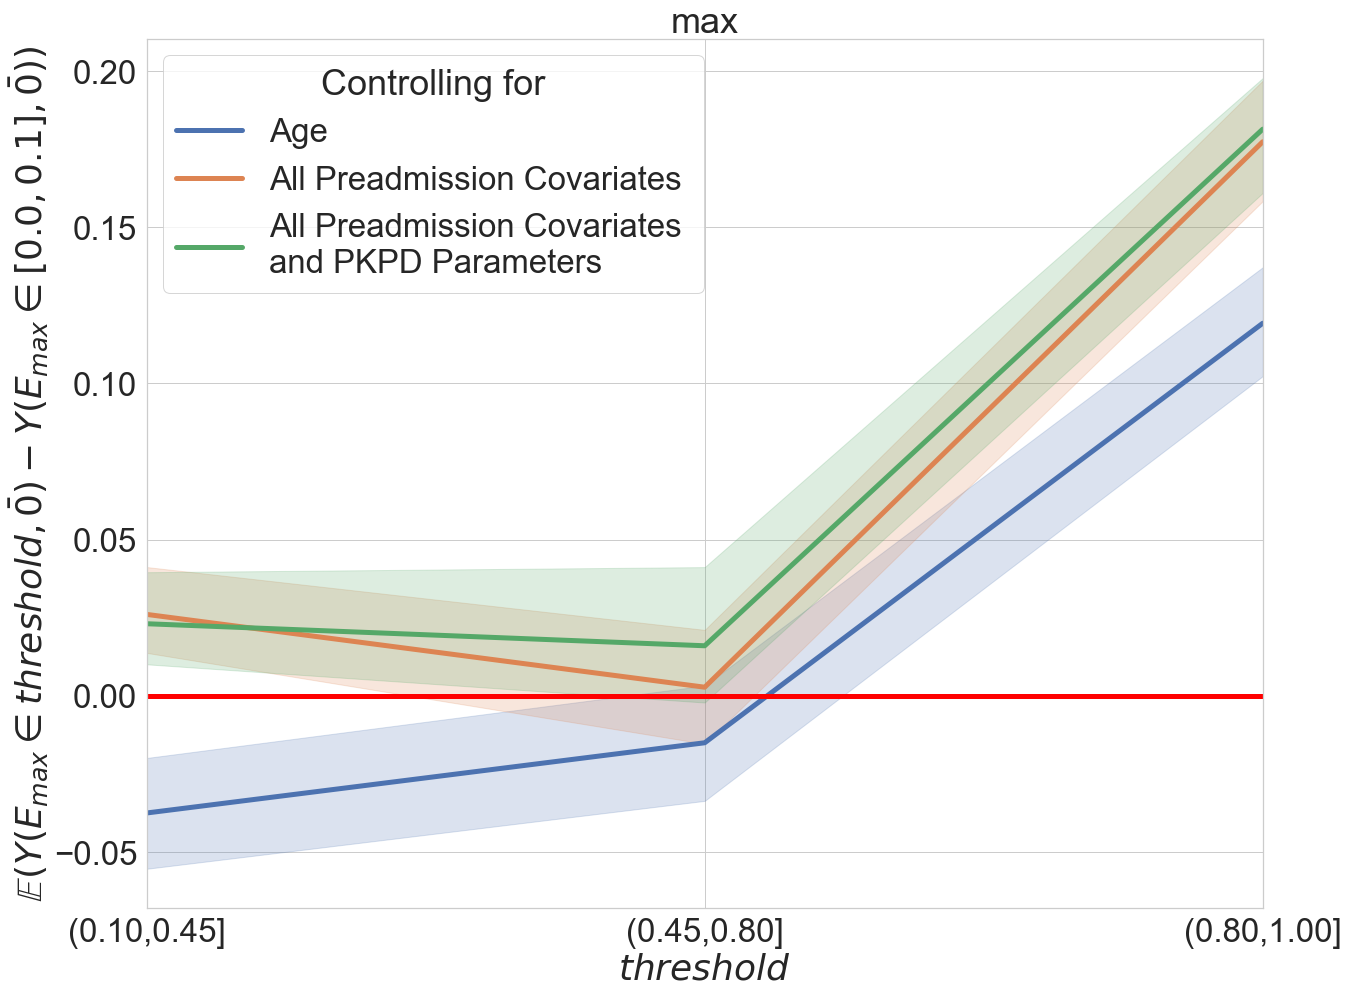

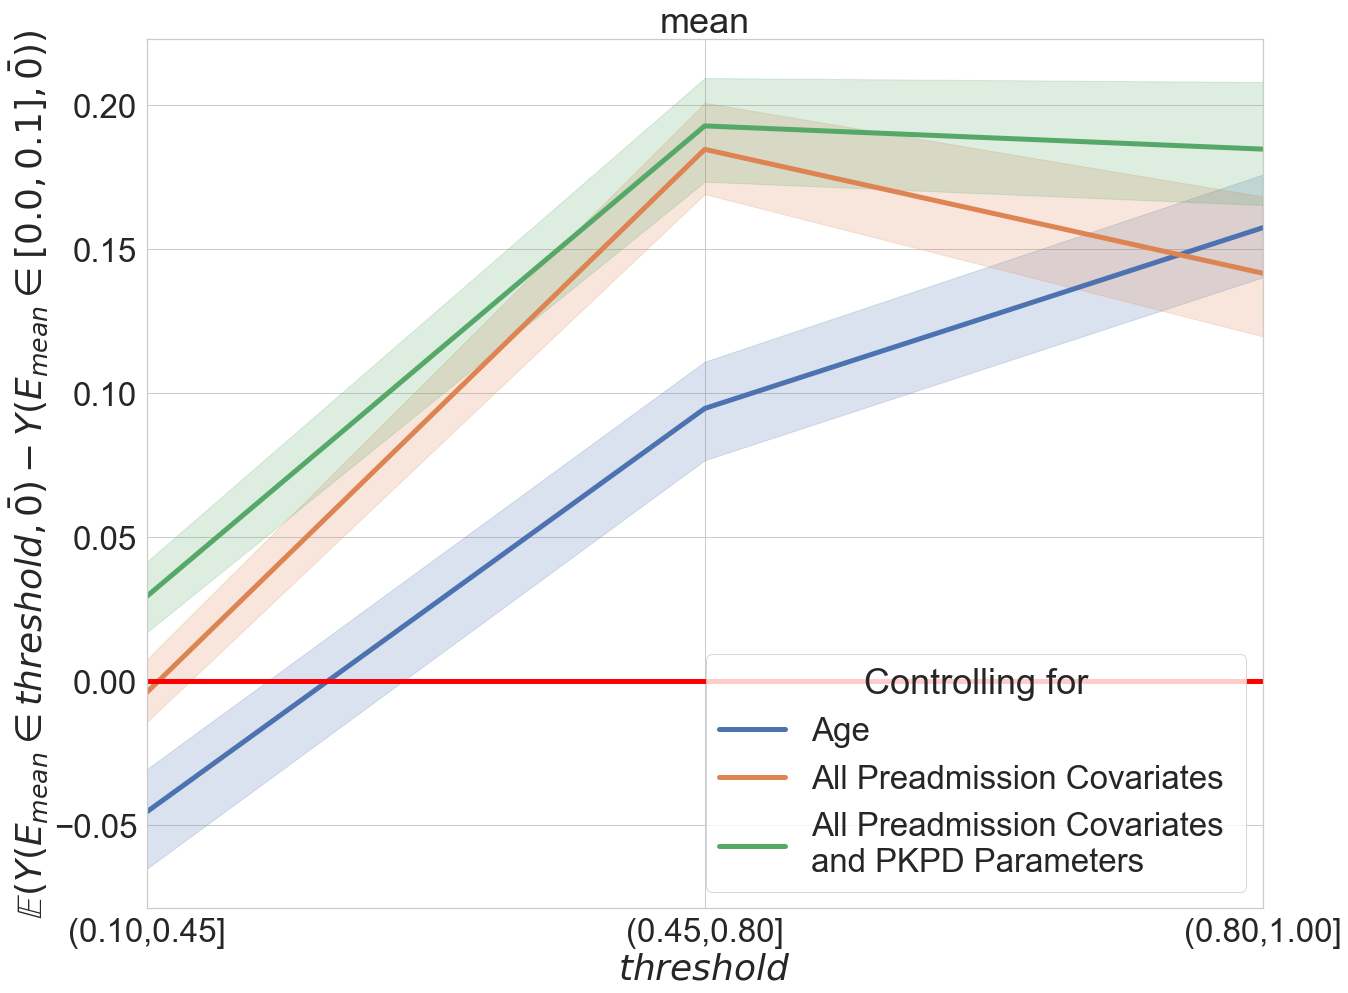

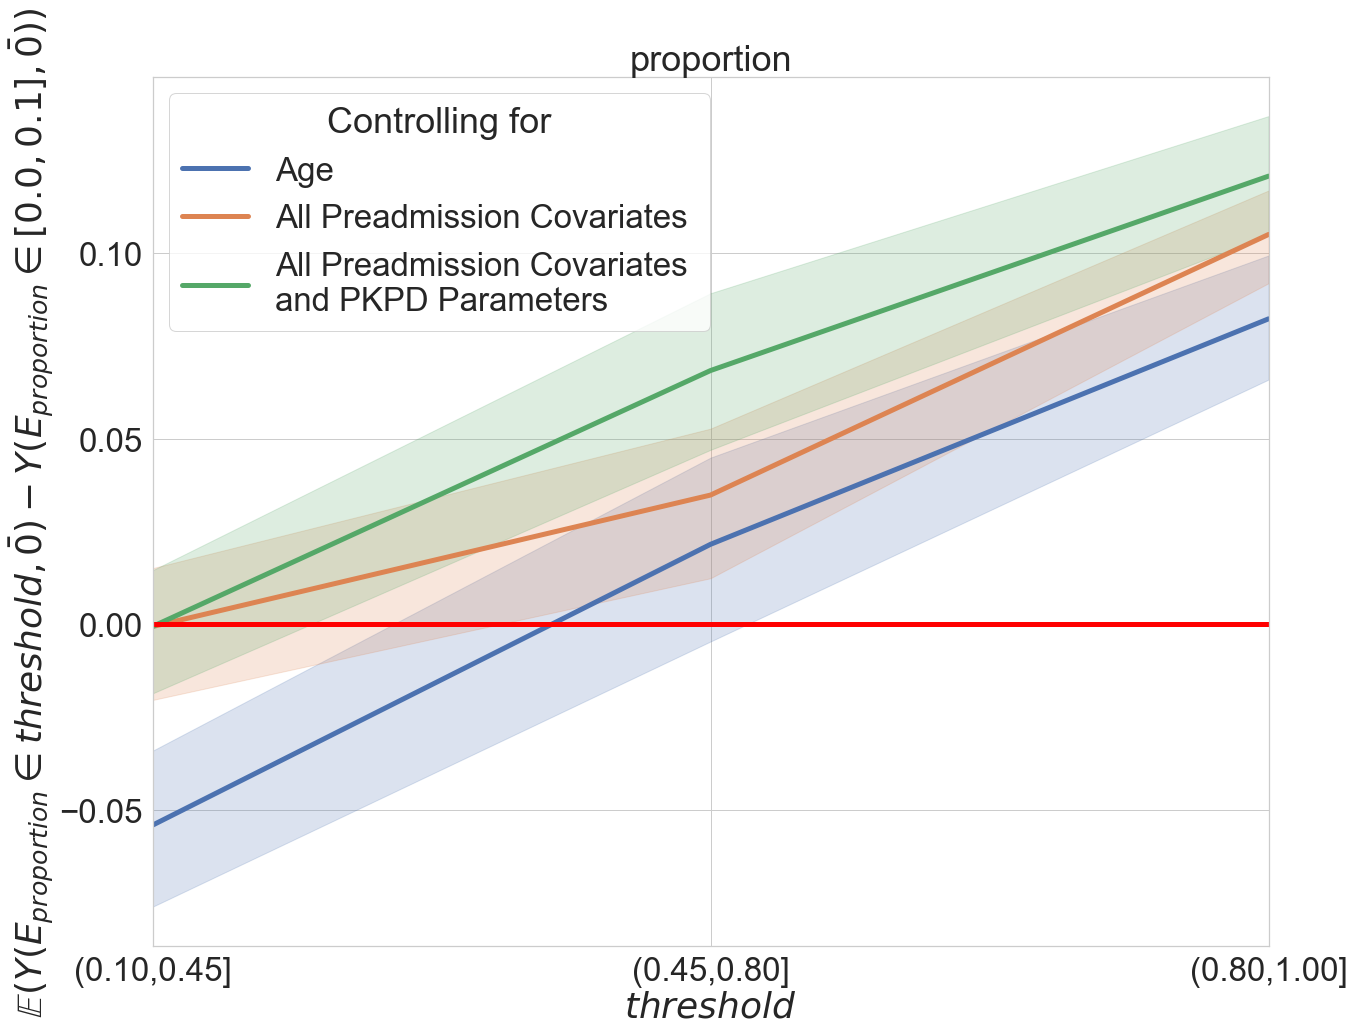

In [57]:
for type_summary in ['max','mean','proportion']:
    fig,ax = plt.subplots(figsize=(20,16))
    for control_var in ['age','c','c_pkpd']:
        df_m_atec =  pd.read_csv('df_m_atec_'+type_summary+'_'+control_var+'.csv')
        levels = list(df_m_atec['Unnamed: 0'])
        df = pd.DataFrame(df_m_atec.drop(columns=['Unnamed: 0']).stack(level=0).droplevel(1),columns=['ATE'])
        df['Level'] = df.index
        sns.lineplot(x='Level',y='ATE',data=df,ci=100,lw=5)
    plt.xlim((0,2))
    plt.legend(['Age','All Preadmission Covariates','All Preadmission Covariates \nand PKPD Parameters'],title="Controlling for")
    plt.xticks([0,1,2],levels)
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('$\\mathbb{E}(Y(E_{%s} \\in threshold, \\bar{0}) - Y(E_{%s} \\in [0.0,0.1],\\bar{0}))$'%(type_summary,type_summary))
    plt.xlabel('$threshold$')
    plt.title('%s'%(type_summary))
    fig.savefig(type_summary+'_line.png')

In [17]:
df_m_atec.drop(columns=['Unnamed: 0'])

,ATE,ATE.1,ATE.2,ATE.3,ATE.4,ATE.5,ATE.6,ATE.7,ATE.8,ATE.9,...,ATE.80,ATE.81,ATE.82,ATE.83,ATE.84,ATE.85,ATE.86,ATE.87,ATE.88,ATE.89
0,0.011650,-0.034862,0.072727,0.002000,0.050000,-0.047170,-0.181513,0.084211,0.016667,0.023853,...,0.141176,0.066071,0.004000,-0.089091,0.006838,0.038776,-0.005607,-0.054545,0.094231,-0.027778
1,0.167347,0.069903,0.032967,-0.002062,0.079167,0.115152,0.075510,0.186000,-0.023404,0.196117,...,0.066055,0.106667,0.049020,0.056000,0.081250,0.059184,0.120408,0.040426,0.119266,-0.020225
2,0.154248,0.180952,0.116901,0.067133,0.209091,0.034483,0.092994,0.171014,0.091156,0.098592,...,0.151678,0.136111,0.148344,0.104762,0.068027,0.209589,0.025503,0.225000,0.026846,0.103546


<AxesSubplot:xlabel='Level', ylabel='ATE'>

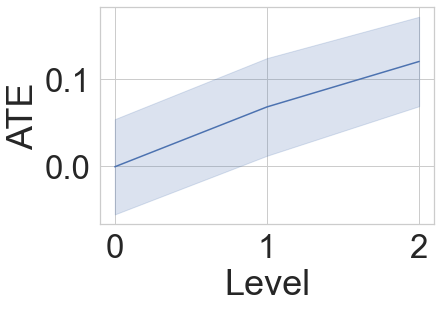

In [26]:
df = pd.DataFrame(df_m_atec.drop(columns=['Unnamed: 0']).stack(level=0).droplevel(1),columns=['ATE'])
df['Level'] = df.index
sns.lineplot(x='Level',y='ATE',data=df,ci='sd')

In [58]:
for type_summary in ['max']:
    for threshold in [0.8]:
        cate_df_max_8 = pd.read_csv('CATES_%s_%.0f.csv'%(type_summary,threshold*10),index_col=0)
        df_max_8 = pd.read_csv('df_malts_estimation_set_%s_%.0f.csv'%(type_summary,threshold*10),index_col=0)

In [61]:
cate_df_max_8[['avg.CATE','Y','T']]
Y1 = cate_df_max_8['T'].values * cate_df_max_8['Y'].values + (1-cate_df_max_8['T'].values) * (cate_df_max_8['Y'].values + cate_df_max_8['avg.CATE'].values)
Y0 = (1-cate_df_max_8['T'].values) * cate_df_max_8['Y'].values + (cate_df_max_8['T'].values) * (cate_df_max_8['Y'].values - cate_df_max_8['avg.CATE'].values)

In [62]:
cate_df_max_8['Y1'] = Y1
cate_df_max_8['Y0'] = Y0

In [63]:
df_full_max_8 = df_max_8.join(cate_df_max_8[['Y1','Y0']])
df_full_max_8

,Gender,Age,marrital,Hx CVA (including TIA),Hx HTN,Hx Sz /epilepsy,Hx brain surgery,Hx CKD,Hx CAD/MI,Hx CHF,...,b[levetiracetam],b[midazolam],b[pentobarbital],b[phenobarbital],b[propofol],b[valproate],Y,T,Y1,Y0
sid2,0.0,85.01,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.008682,0.000000,0.0,0.0,0.000000,0.000000,True,True,1.000000,0.846171
sid3,1.0,45.91,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.966040,0.000000,0.0,0.0,0.000000,0.000000,True,True,1.000000,0.775332
sid4,1.0,53.99,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.010657,0.000000,0.0,0.0,0.039377,0.000000,True,True,1.000000,0.841138
sid17,0.0,35.03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,18.911908,0.0,0.0,0.393039,0.048042,True,True,1.000000,0.662676
sid18,1.0,60.20,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,2.074762,0.000000,0.0,0.0,0.034884,2.101319,True,True,1.000000,0.750996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sid1961,0.0,62.38,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,30.497850,0.000000,0.0,0.0,2.416036,0.000000,False,False,0.176306,0.000000
sid1964,1.0,76.52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,5.843972,0.000000,0.0,0.0,17.681718,0.000000,True,False,1.141398,1.000000
sid1985,1.0,50.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.285896,0.000000,0.0,0.0,11.085294,0.000000,True,False,1.151802,1.000000
sid1997,1.0,60.44,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,True,False,1.174807,1.000000


In [64]:
columns = ['20-40','40-60','70+']
index = ['% mRS $\\leq$ 3','% mRS > 3']
mat0 = np.zeros((2,3))
mat1 = np.zeros((2,3))
for i in df_full_max_8.index:
    age = df_full_max_8.loc[i,'Age']
    if age<40:
        mat0[1,0] += df_full_max_8.loc[i,'Y0']
        mat1[1,0] += df_full_max_8.loc[i,'Y1']
        mat0[0,0] += 1-df_full_max_8.loc[i,'Y0']
        mat1[0,0] += 1-df_full_max_8.loc[i,'Y1']
    elif age<60:
        mat0[1,1] += df_full_max_8.loc[i,'Y0']
        mat1[1,1] += df_full_max_8.loc[i,'Y1']
        mat0[0,1] += 1-df_full_max_8.loc[i,'Y0']
        mat1[0,1] += 1-df_full_max_8.loc[i,'Y1']
    elif age>60:
        mat0[1,2] += df_full_max_8.loc[i,'Y0']
        mat1[1,2] += df_full_max_8.loc[i,'Y1']
        mat0[0,2] += 1-df_full_max_8.loc[i,'Y0']
        mat1[0,2] += 1-df_full_max_8.loc[i,'Y1']

mat0[:,0] = mat0[:,0]*100.0/np.sum(mat0[:,0])
mat0[:,1] = mat0[:,1]*100.0/np.sum(mat0[:,1])
mat0[:,2] = mat0[:,2]*100.0/np.sum(mat0[:,2])

mat1[:,0] = mat1[:,0]*100.0/np.sum(mat1[:,0])
mat1[:,1] = mat1[:,1]*100.0/np.sum(mat1[:,1])
mat1[:,2] = mat1[:,2]*100.0/np.sum(mat1[:,2])

df_mat0 = pd.DataFrame(mat0,columns=columns,index=index)
df_mat1 = pd.DataFrame(mat1,columns=columns,index=index)

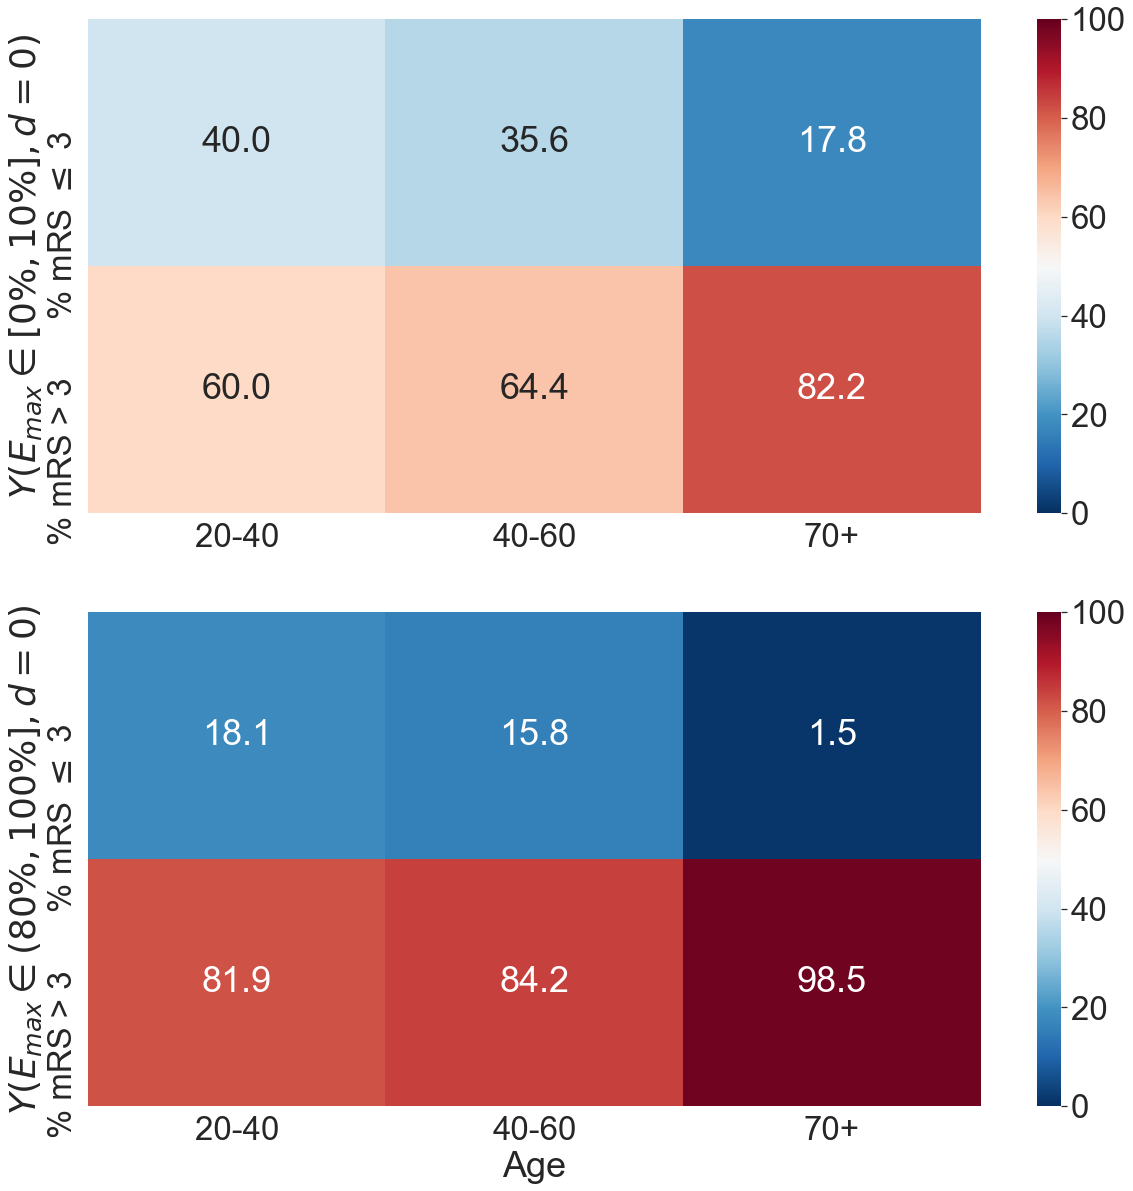

In [80]:
fig,ax = plt.subplots(nrows=2,figsize=(20,20))
sns.heatmap(df_mat0,annot=True,cmap="RdBu_r",center=50, ax = ax[0], fmt='.1f', vmin=0, vmax=100)
ax[0].set_ylabel('$Y(E_{max} \\in [0\%,10\%], d = 0 )$')
sns.heatmap(df_mat1,annot=True,cmap="RdBu_r",center=50, ax=ax[1], fmt='.1f', vmin=0, vmax=100)
ax[1].set_ylabel('$Y(E_{max} \\in (80\%,100\%], d = 0 )$')
plt.xlabel('Age')
plt.savefig('y_age.png')

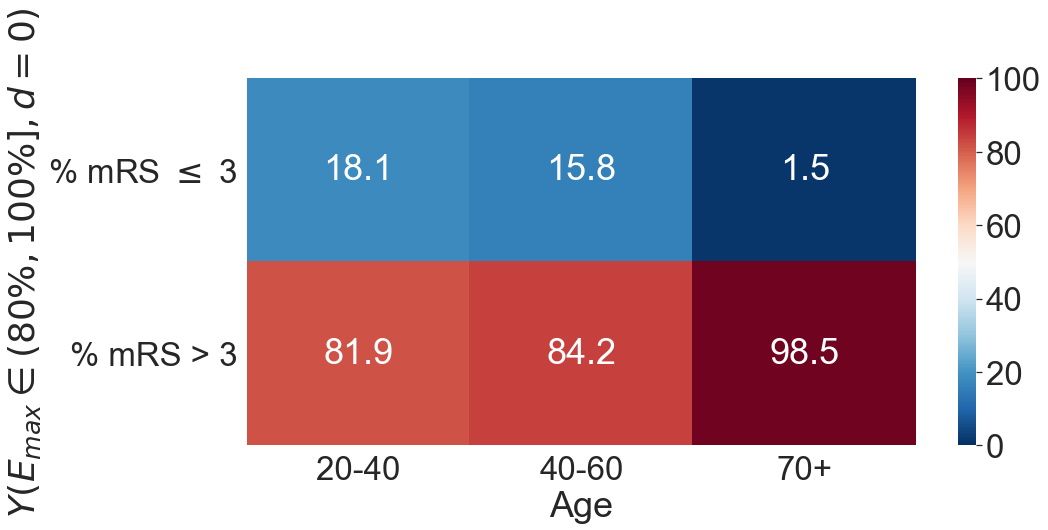

In [74]:
plt.figure(figsize=(15,6.75))
sns.heatmap(df_mat1,annot=True,cmap="RdBu_r",center=50,fmt='.1f', vmin=0, vmax=100)
plt.ylabel('$Y(E_{max} \\in (80\%,100\%], d = 0 )$')
plt.xlabel('Age')
plt.savefig('y1_age.png')

In [88]:
columns = ['No','Yes']
index = ['% mRS $\\leq$ 3','% mRS > 3']
mat0 = np.zeros((2,2))
mat1 = np.zeros((2,2))
for i in df_full_max_8.loc[df_full_max_8['Age']<60].index:
    mv = df_full_max_8.loc[i,'iMV  (initial (on admission) mechanical ventilation)']
    if mv==0:
        mat0[1,0] += df_full_max_8.loc[i,'Y0']
        mat1[1,0] += df_full_max_8.loc[i,'Y1']
        mat0[0,0] += 1-df_full_max_8.loc[i,'Y0']
        mat1[0,0] += 1-df_full_max_8.loc[i,'Y1']
    elif mv==1:
        mat0[1,1] += df_full_max_8.loc[i,'Y0']
        mat1[1,1] += df_full_max_8.loc[i,'Y1']
        mat0[0,1] += 1-df_full_max_8.loc[i,'Y0']
        mat1[0,1] += 1-df_full_max_8.loc[i,'Y1']

mat0[:,0] = mat0[:,0]*100.0/np.sum(mat0[:,0])
mat0[:,1] = mat0[:,1]*100.0/np.sum(mat0[:,1])

mat1[:,0] = mat1[:,0]*100.0/np.sum(mat1[:,0])
mat1[:,1] = mat1[:,1]*100.0/np.sum(mat1[:,1])

df_mat0 = pd.DataFrame(mat0,columns=columns,index=index)
df_mat1 = pd.DataFrame(mat1,columns=columns,index=index)

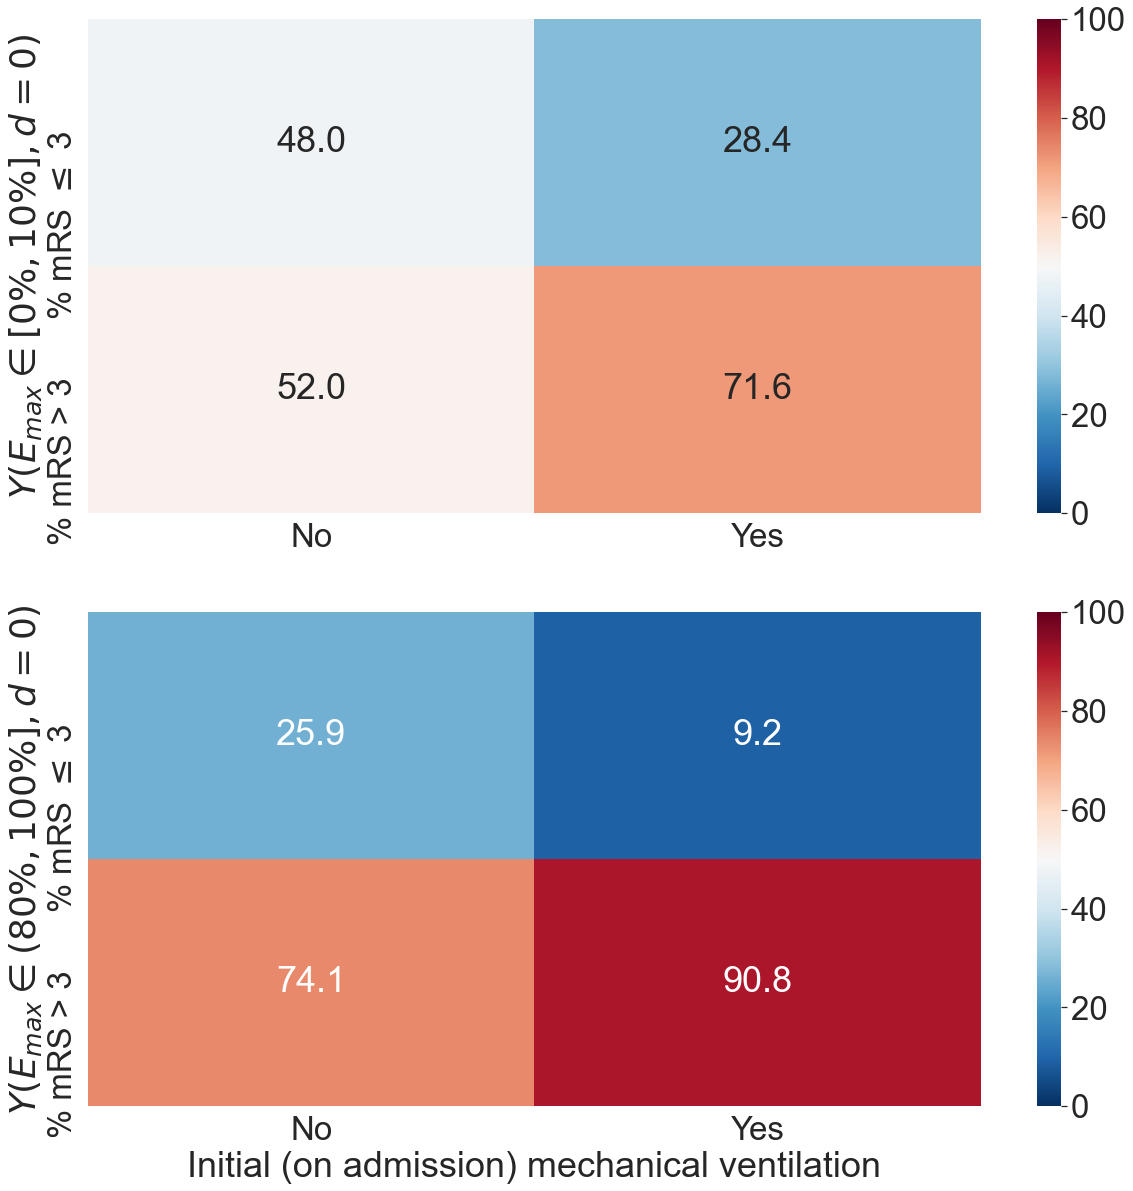

In [89]:
fig,ax = plt.subplots(nrows=2,figsize=(20,20))
sns.heatmap(df_mat0,annot=True,cmap="RdBu_r",center=50, ax = ax[0], fmt='.1f', vmin=0, vmax=100)
ax[0].set_ylabel('$Y(E_{max} \\in [0\%,10\%], d = 0 )$')
sns.heatmap(df_mat1,annot=True,cmap="RdBu_r",center=50, ax=ax[1], fmt='.1f', vmin=0, vmax=100)
ax[1].set_ylabel('$Y(E_{max} \\in (80\%,100\%], d = 0 )$')
plt.xlabel('Initial (on admission) mechanical ventilation')
plt.savefig('y_imv.png')